# 라이브러리

In [ ]:
! pip install konlpy

In [ ]:
# 코랩에서 한글폰트 사용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = (12,16)
plt.rcParams['font.size'] = 20

# 그래프 그릴 때 마이너스(-) 부분도 표시해주기
plt.rcParams['axes.unicode_minus'] = False

# 사용자 정의 함수

In [84]:
def age_change(age):
    if age < 20:
        result = 1
    elif age < 30:
        result = 2
    elif age < 40:
        result = 3
    elif age < 50:
        result = 4
    elif age < 60:
        result = 5
    else:
        result = 6
    return result


def text_preprocess(data):
    text = str(data)
    new_text = re.sub(r'[^가-힣]', ' ', text)

    okt = Okt()
    tokens = okt.pos(new_text)
    new_words = []
    for word, tag in tokens:
        if tag not in ['Josa', 'Suffix']:
            new_words.append(word)
    new_text = ' '.join(new_words)

    #prepro_text = ' '.join(okt.morphs(new_text, stem=True))
    return new_text


# 빈도분석 후 결과 출력
def count_analyze(texts, count_vec, color, title):
    
    count_vec.fit(texts)
    
    word_dict = sorted(count_vec.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}

    total_text = []
    total_text.append(' '.join(texts.values))

    count_matrix = count_vec.transform(total_text)

    count_word = []
    count_vector = []

    for i in range(10,0,-1):
        count_word.append(idx2word[(-count_matrix.toarray()[0]).argsort()[i-1]])
        count_vector.append(count_matrix.toarray()[0][(-count_matrix.toarray()[0]).argsort()[i-1]])

    print(count_word)
    print(count_vector)

    plt.figure(figsize=(12,16))
    plt.barh(count_word, count_vector, color=color)
    plt.yticks(count_word)
    plt.title(f'{title} 빈도 분석')
    plt.show()

    return count_word, count_vector


# TF-IDF 생성 함수
def tfidf_analyze(fit_data, analysis_data, vec, color, title):
    vec.fit(fit_data)

    word_dict = sorted(vec.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}

    total_text = []
    total_text.append(' '.join(analysis_data.values))

    matrix = vec.transform(total_text)

    word = []
    vector = []

    for i in range(10,0,-1):
        word.append(idx2word[matrix.toarray()[0].argsort()[-i]])
        vector.append(matrix.toarray()[0][matrix.toarray()[0].argsort()[-i]])

    print(word)
    print(vector)

    plt.figure(figsize=(12,16))
    plt.barh(word, vector, color=color)
    plt.yticks(word)
    plt.title(f'{title} TF-IDF')
    plt.show()

    return word, vector

    
# 코사인 유사도 문장 매칭
def cosine_sim_matching(vectorizer, fit_text, transform_text, word_list, raw_text):
    # 비교할 전체 텍스트 적합
    vectorizer.fit(fit_text)
    rep_df = pd.DataFrame(columns=['선택단어', '대표문장', '코사인유사도'])

    for text in word_list[::-1]:

        # 선택한 단어들 벡터화
        selected_word = pd.Series([text])
        selected_word_vec = vectorizer.transform(selected_word)
        
        # 전체 문장 벡터화
        total_text = vectorizer.transform(transform_text)

        # 코사인 유사도
        cosine_sim = cosine_similarity(selected_word_vec, total_text)

        sim_score = []
        sentence = []
        for i in range(5):
            sim_score.append(cosine_sim[0][cosine_sim[0].argsort()[-(i+1)]])
            sentence.append(raw_text.iloc[cosine_sim[0].argsort()[-(i+1)]])

        cosine_df = pd.DataFrame({
            '선택단어' : [text, np.nan,np.nan,np.nan,np.nan],
            '대표문장' : sentence,
            '코사인유사도' : sim_score
        })

        rep_df = rep_df.append(cosine_df, ignore_index=True)

    return rep_df


# 1ngram용 코사인 유사도 문장 매칭
def cosine_sim_1ngram(vectorizer, fit_text, transform_text, word_list, raw_text, cnt):
    # 비교할 전체 텍스트 적합
    new_text = []
    new_text.append(' '.join(word_list[::-1]))

    vectorizer.fit(fit_text)
    rep_text = vectorizer.transform(new_text)
    prepro_text = vectorizer.transform(transform_text)

    cosine_1ngram = cosine_similarity(rep_text, prepro_text)

    cosine_score = []
    selected_sentence = []

    for i in range(cnt):
        cosine_score.append(cosine_1ngram[0][cosine_1ngram[0].argsort()[-(i+1)]])
        selected_sentence.append(raw_text.iloc[cosine_1ngram[0].argsort()[-(i+1)]])

    rep_1ngram_df = pd.DataFrame({
        f"'{new_text[0]}' → 대표문장" : selected_sentence,
        '코사인유사도' : cosine_score
    })

    return rep_1ngram_df



# 로그 오즈비 구하기
def log_odds_ratio(count_vec, prepro_data1, prepro_data2, count_word1, count_word2, title):

  # 빈도분석으로 뽑은 단어들 공통 단어 빼고, 유일한 단어들로 정리
  count_word_list = list(set(count_word1 + count_word2))

  #################################################################
  # 첫 번째 (기준 데이터)
  # 기준으로 정한 데이터로 다시 적합시키기
  count_vec.fit(prepro_data1)

  # 우리가 원하는 빈도 수치 뽑기 위한 데이터 정리
  join_text1 = []
  join_text1.append(' '.join(prepro_data1.values))

  # 빈도 뽑아내기
  count_transform1 = count_vec.transform(join_text1)

  # 단어사전 만들기
  word2idx1 = {word:idx for word, idx in count_vec.vocabulary_.items()}

  # 첫번째 데이터에 대한 확인 할 단어 빈도 수치 뽑기
  text_vector1 = []
  for word in count_word_list:
    if word in word2idx1.keys():
      text_vector1.append(count_transform1.toarray()[0][word2idx1[word]])
    else:
      text_vector1.append(0)

  #################################################################

  # 두 번째 (비교 데이터)
  # 다시 적합시키기
  count_vec.fit(prepro_data2)

  # 우리가 원하는 빈도 수치 뽑기 위한 데이터 정리
  join_text2 = []
  join_text2.append(' '.join(prepro_data2.values))

  # 빈도 뽑아내기
  count_transform2 = count_vec.transform(join_text2)

  # 단어사전 만들기
  word2idx2 = {word:idx for word, idx in count_vec.vocabulary_.items()}

  # 두번째 데이터에 대한 확인 할 단어 빈도 수치 뽑기
  text_vector2 = []
  for word in count_word_list:
    if word in word2idx2.keys():
      text_vector2.append(count_transform2.toarray()[0][word2idx2[word]])
    else:
      text_vector2.append(int(0))

  #################################################################

  # 빈도 수치 데이터 프레임 만들기
  count_df = pd.DataFrame({
      'word' : count_word_list,
      'data1' : text_vector1,
      'data2' : text_vector2
  })

  # count_df.sort_values(by='data1', axis=0, ascending=False, inplace=True)
  count_df['odds1'] = (count_df['data1']/sum(count_df['data1'])) / (1 - (count_df['data1']/sum(count_df['data1']))) # 기준데이터 odds 구하기
  count_df['odds2'] = (count_df['data2']/sum(count_df['data2'])) / (1 - (count_df['data2']/sum(count_df['data2']))) # 비교데이터 odds 구하기
  count_df['odds_ratio'] = count_df['odds1'] / count_df['odds2']  # ==> 오즈비 구하기
  count_df['log_odds_ratio'] = np.log(count_df['odds_ratio'])     # ==> 로그 오즈비 구하기
  count_df.sort_values(by='log_odds_ratio', ascending=False, inplace=True)  # ==> 로그 오즈비 기준으로 내림차순 정렬하기
  count_df['positive'] = count_df['log_odds_ratio'] > 0

  # 무한대값은 제거하자
  count_df = count_df[count_df['log_odds_ratio'] != np.inf]

  plt.barh(count_df['word'].values[::-1], count_df['log_odds_ratio'].values[::-1], color=count_df['positive'][::-1].map({True:'skyblue', False:'lightpink'}))
  plt.title(f'{title} 로그오즈비 비교')
  plt.yticks(count_df['word'].values[::-1])
  plt.show()

  return count_df

# 데이터 로드

In [ ]:
path = 'text.xlsx'
df = pd.read_excel(path)
df

# 데이터 분리

In [5]:
# 성별 (sq1) / 1=남성 , 2=여성
male = df[['SQ1', 'Q1t1' , 'Q2t1']][df['SQ1']==1]
female = df[['SQ1', 'Q1t1' , 'Q2t1']][df['SQ1']==2]

#print(male.shape) # ==> (9784, 3)
#print(female.shape) # ==> (15591, 3)


In [6]:
# 결측치 제거한 실사용 데이터
male_q1 = male['Q1t1'] [male['Q1t1'].notnull()]
female_q1 = female['Q1t1'] [female['Q1t1'].notnull()]

male_q2 = male['Q2t1'] [male['Q2t1'].notnull()]
female_q2 = female['Q2t1'] [female['Q2t1'].notnull()]

In [ ]:
# 나이(SQ2t1)
age = df[['SQ2t1', 'Q1t1' , 'Q2t1']]
age['SQ2t1'] = age['SQ2t1'].map(age_change)
age

In [8]:
# 결측치 제거한 실사용 데이터
age10_q1 = age['Q1t1'][age['SQ2t1']==1]  
age20_q1 = age['Q1t1'][age['SQ2t1']==2]
age30_q1 = age['Q1t1'][age['SQ2t1']==3]
age40_q1 = age['Q1t1'][age['SQ2t1']==4]
age50_q1 = age['Q1t1'][age['SQ2t1']==5]
age60_q1 = age['Q1t1'][age['SQ2t1']==6]

age10_q2 = age['Q2t1'][age['SQ2t1']==1]  
age20_q2 = age['Q2t1'][age['SQ2t1']==2]
age30_q2 = age['Q2t1'][age['SQ2t1']==3]
age40_q2 = age['Q2t1'][age['SQ2t1']==4]
age50_q2 = age['Q2t1'][age['SQ2t1']==5]
age60_q2 = age['Q2t1'][age['SQ2t1']==6]

# 40대 미만 vs 40대 이상
age_under40_q1 = age['Q1t1'][age['SQ2t1'] < 4]
age_over40_q1 = age['Q1t1'][age['SQ2t1'] >= 4]

age_under40_q2 = age['Q2t1'][age['SQ2t1'] < 4]
age_over40_q2 = age['Q2t1'][age['SQ2t1'] >= 4]

In [ ]:
# 연령대 데이터 전체 하나로 묶기
allage_q1 = pd.concat([age10_q1[age10_q1.notnull()], age20_q1[age20_q1.notnull()], age30_q1[age30_q1.notnull()],
                       age40_q1[age40_q1.notnull()], age50_q1[age50_q1.notnull()], age60_q1[age60_q1.notnull()]], axis=0)
allage_q1

# 데이터 전처리

In [10]:
# Q1 새로운 대통령에게 여러분이 기대하는 역량과 자질은 무엇인가요?
prepro_male_q1 = male_q1.map(text_preprocess)
prepro_female_q1 = female_q1.map(text_preprocess)

prepro_age10_q1 = age10_q1[age10_q1.notnull()].map(text_preprocess)
prepro_age20_q1 = age20_q1[age20_q1.notnull()].map(text_preprocess)
prepro_age30_q1 = age30_q1[age30_q1.notnull()].map(text_preprocess)
prepro_age40_q1 = age40_q1[age40_q1.notnull()].map(text_preprocess)
prepro_age50_q1 = age50_q1[age50_q1.notnull()].map(text_preprocess)
prepro_age60_q1 = age60_q1[age60_q1.notnull()].map(text_preprocess)

prepro_allage_q1 = pd.concat([prepro_age10_q1, prepro_age20_q1, prepro_age30_q1, prepro_age40_q1, prepro_age50_q1, prepro_age60_q1], axis=0)

prepro_age_under40_q1 =  age_under40_q1[age_under40_q1.notnull()].map(text_preprocess)
prepro_age_over40_q1 = age_over40_q1[age_over40_q1.notnull()].map(text_preprocess)

In [11]:
# Q2 왜 그 역량과 자질이 필요하다고 생각하시나요?
prepro_male_q2 = male_q2.map(text_preprocess)
prepro_female_q2 = female_q2.map(text_preprocess)

prepro_age10_q2 = age10_q2[age10_q2.notnull()].map(text_preprocess)
prepro_age20_q2 = age20_q2[age20_q2.notnull()].map(text_preprocess)
prepro_age30_q2 = age30_q2[age30_q2.notnull()].map(text_preprocess)
prepro_age40_q2 = age40_q2[age40_q2.notnull()].map(text_preprocess)
prepro_age50_q2 = age50_q2[age50_q2.notnull()].map(text_preprocess)
prepro_age60_q2 = age60_q2[age60_q2.notnull()].map(text_preprocess)

prepro_allage_q2= pd.concat([prepro_age10_q2, prepro_age20_q2, prepro_age30_q2, prepro_age40_q2, prepro_age50_q2, prepro_age60_q2], axis=0)

prepro_age_under40_q2 = age_under40_q2[age_under40_q2.notnull()].map(text_preprocess)
prepro_age_over40_q2 = age_over40_q2[age_over40_q2.notnull()].map(text_preprocess)

# TF-IDF

## 성별 비교

In [12]:
# 불용어사전
stop_words1 = ['있는', '하는']

# 백터라이저
tfidf_ngram1 = TfidfVectorizer(
    stop_words=stop_words1,
    min_df = 50,
    ngram_range = (1,1),
    max_features = 50
)

##########################

# 불용어사전
stop_words2 = ['있는', '하는']

# 백터라이저
tfidf_ngram2 = TfidfVectorizer(
    stop_words=stop_words2,
    min_df = 50,
    ngram_range = (2,2),
    max_features = 50
)

##########################

# 불용어사전
stop_words3 = ['필요하다고']

# 백터라이저
tfidf_ngram3 = TfidfVectorizer(
    stop_words=stop_words3,
    min_df = 10,
    ngram_range = (3,3),
    max_features = 50
)

In [ ]:
# TF-IDF 그래프 & 단어,vector 추출

word_male1_q1, vec_male1_q1 = tfidf_analyze(prepro_female_q1, prepro_male_q1, tfidf_ngram1, 'skyblue', '남성')
word_female1_q1, vec_female1_q1 = tfidf_analyze(prepro_male_q1, prepro_female_q1, tfidf_ngram1, 'lightpink', '여성')

word_male2_q1, vec_male2_q1 = tfidf_analyze(prepro_female_q1, prepro_male_q1, tfidf_ngram2, 'skyblue', '남성')
word_female2_q1, vec_female2_q1 = tfidf_analyze(prepro_male_q1, prepro_female_q1, tfidf_ngram2, 'lightpink', '여성')

word_male3_q1, vec_male3_q1 = tfidf_analyze(prepro_female_q1, prepro_male_q1, tfidf_ngram3, 'skyblue', '남성')
word_female3_q1, vec_female3_q1 = tfidf_analyze(prepro_male_q1, prepro_female_q1, tfidf_ngram3, 'lightpink', '여성')

### 코사인 유사도 매칭 대표문장

In [ ]:
# Q1
# 1ngram 용 남성
q1_male_1ngram_cos_df = cosine_sim_1ngram(tfidf_ngram1, prepro_female_q1, prepro_male_q1, word_male1_q1, male_q1, 10)
# q1_male_1ngram_cos_df.to_csv('./Q1_남성(1ngram).csv', encoding='utf-8-sig', index=False)

# 1ngram 용 여성
q1_female_1ngram_cos_df = cosine_sim_1ngram(tfidf_ngram1, prepro_male_q1, prepro_female_q1, word_female1_q1, female_q1, 10)
# q1_female_1ngram_cos_df.to_csv('./Q1_여성(1ngram).csv', encoding='utf-8-sig', index=False)

In [37]:
# Q1
# 2ngram 용 남성
q1_male_2ngram_df  = cosine_sim_matching(tfidf_ngram2, prepro_female_q1, prepro_male_q1, word_male2_q1, male_q1)
# q1_male_2ngram_df.to_csv('./Q1_남성(2ngram).csv', encoding='utf-8-sig', index=False)

# 2ngram 용 여성
q1_female_2ngram_df  = cosine_sim_matching(tfidf_ngram2, prepro_male_q1, prepro_female_q1, word_female2_q1, female_q1)
# q1_female_2ngram_df.to_csv('./Q1_여성(2ngram).csv', encoding='utf-8-sig', index=False)

In [ ]:
# Q1
# 3ngram 용 남성
q1_male_df  = cosine_sim_matching(tfidf_ngram3, prepro_female_q1, prepro_male_q1, word_male3_q1, male_q1)
# q1_male_df.to_csv('./Q1_남성.csv', encoding='utf-8-sig', index=False)

# 3ngram 용 여성
q1_female_df  = cosine_sim_matching(tfidf_ngram3, prepro_male_q1, prepro_female_q1,word_female3_q1,female_q1)
# q1_female_df.to_csv('./Q1_여성.csv', encoding='utf-8-sig', index=False)

In [17]:
# 불용어사전
stop_words1_q2 = ['있는', '하는', '때문', '너무', '위해', '지금', '생각', '현재', '한다', '합니다']

# 백터라이저
tfidf_ngram1_q2 = TfidfVectorizer(
    stop_words=stop_words1_q2,
    min_df = 50,
    ngram_range = (1,1),
    max_features = 50
)

##########################

# 불용어사전
stop_words2_q2 = ['있는', '하는', '이기', '때문', '생각', '하기', '있기', '입니다', '필요하다고', '하기', '위해', '한다', '합니다', '한다고', '있다고', '역량', '자질', '역대', '지금', '가장', '해야']

# 백터라이저
tfidf_ngram2_q2 = TfidfVectorizer(
    stop_words=stop_words2_q2,
    min_df = 30,
    ngram_range = (2,2),
    max_features = 50
)

##########################

# 불용어사전
stop_words3_q2 = ['있는', '하는', '이기', '때문', '생각', '하기', '있기', '입니다', '필요하다고', '하기', '위해', '한다', '합니다', '한다고', '있다고', '해야', '인해', '사람', '역량', '자질', '가장', '문제']

# 백터라이저
tfidf_ngram3_q2 = TfidfVectorizer(
    stop_words=stop_words3_q2,
    min_df = 5,
    ngram_range = (3,3),
    max_features = 50
)

['사람', '문제', '정책', '대한민국', '국가', '경제', '사회', '나라', '대통령', '국민']
[0.17490977033400473, 0.18872045129478024, 0.18972556199580287, 0.20106099583164727, 0.20472586377028487, 0.2594557395918248, 0.2609041870719356, 0.27047176045947774, 0.3045179611483616, 0.38037402525460806]


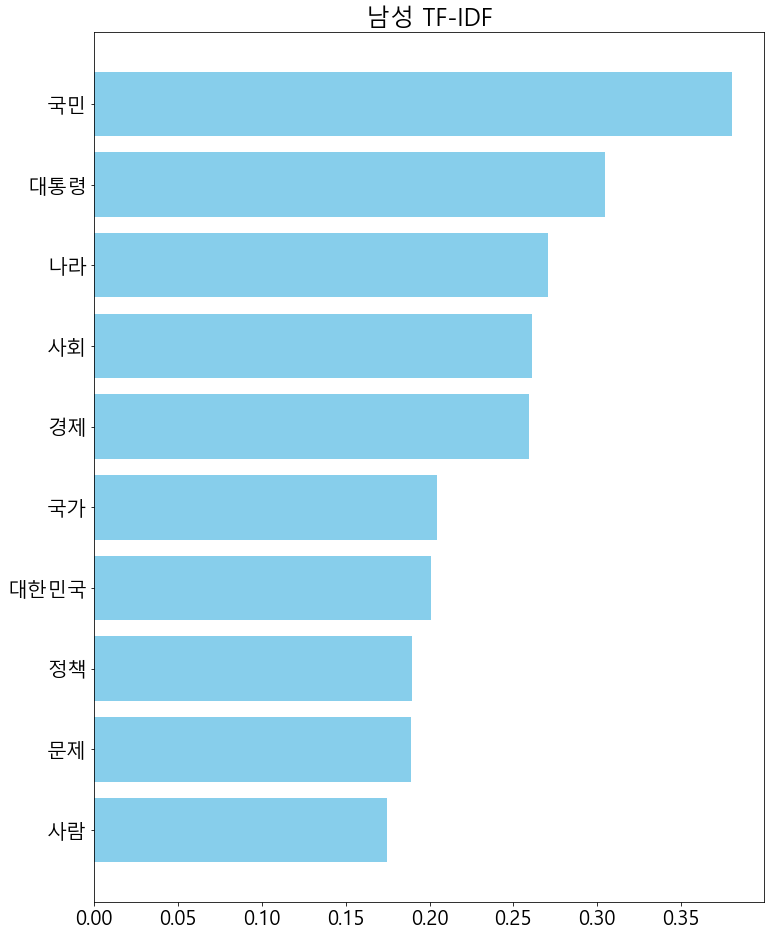

['가장', '사회', '코로나', '문제', '정책', '경제', '사람', '나라', '대통령', '국민']
[0.12200885580128105, 0.1364833301042945, 0.1599097611292525, 0.1613763256927516, 0.175942105272009, 0.1975135783516068, 0.311866790220948, 0.3440634241763874, 0.34612714827196317, 0.43580023559121006]


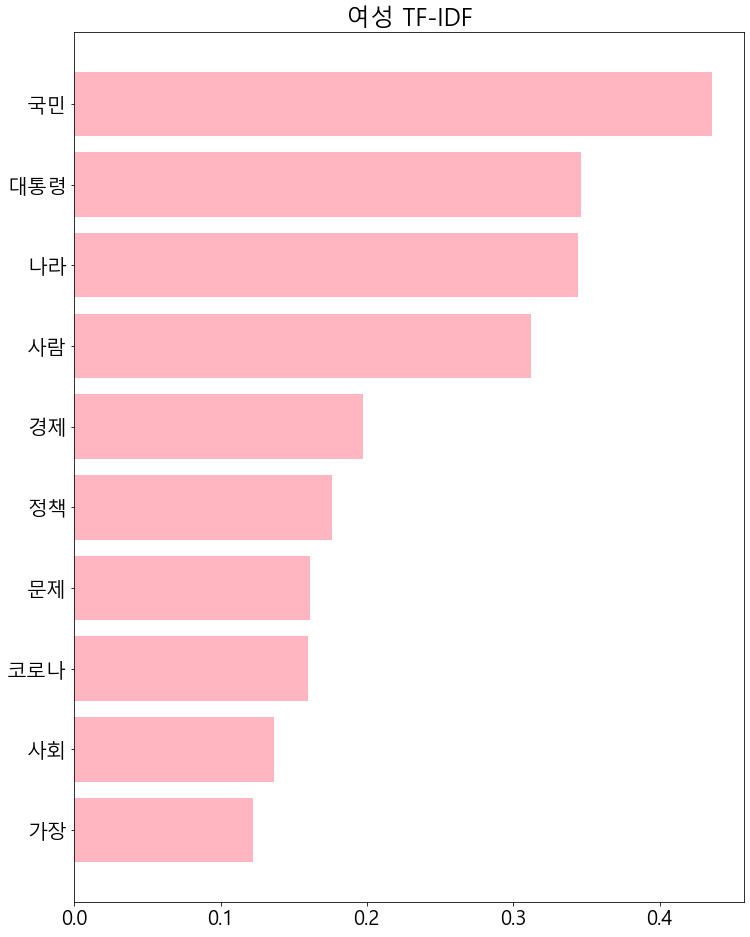

['부동산 정책', '코로나 인한', '부동산 가격', '모든 국민', '경제 발전', '현재 우리나라', '나라 발전', '코로나 인해', '국정 운영', '문제 해결']
[0.16839573591017065, 0.18413948255985535, 0.18953402285295706, 0.19008386124897148, 0.1977115834723793, 0.1977115834723793, 0.23785971157361077, 0.24925488289966072, 0.3085429779511694, 0.33284301386360177]


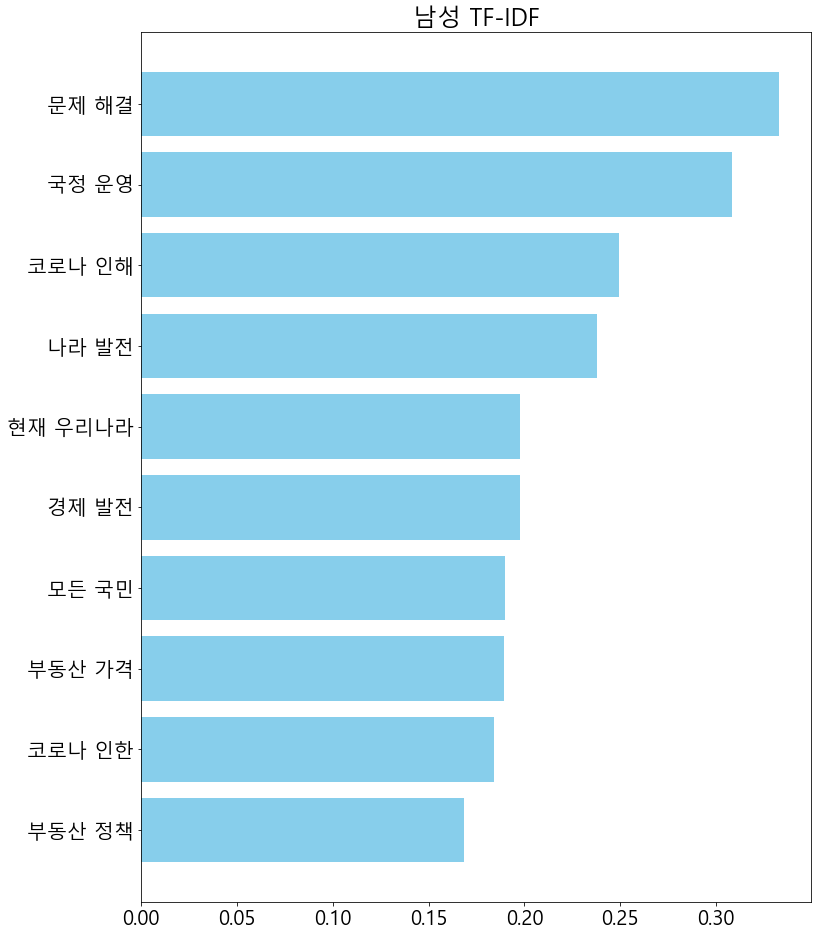

['부동산 가격', '코로나 인한', '부동산 정책', '국민 소통', '문제 해결', '모든 국민', '나라 발전', '집값 너무', '국민 대표', '코로나 인해']
[0.2136053999012346, 0.2569456259681518, 0.2788247575941172, 0.27998618580026496, 0.28934823316713065, 0.2898931500222232, 0.29913145191019086, 0.32192280691418, 0.364910636266719, 0.386369710643723]


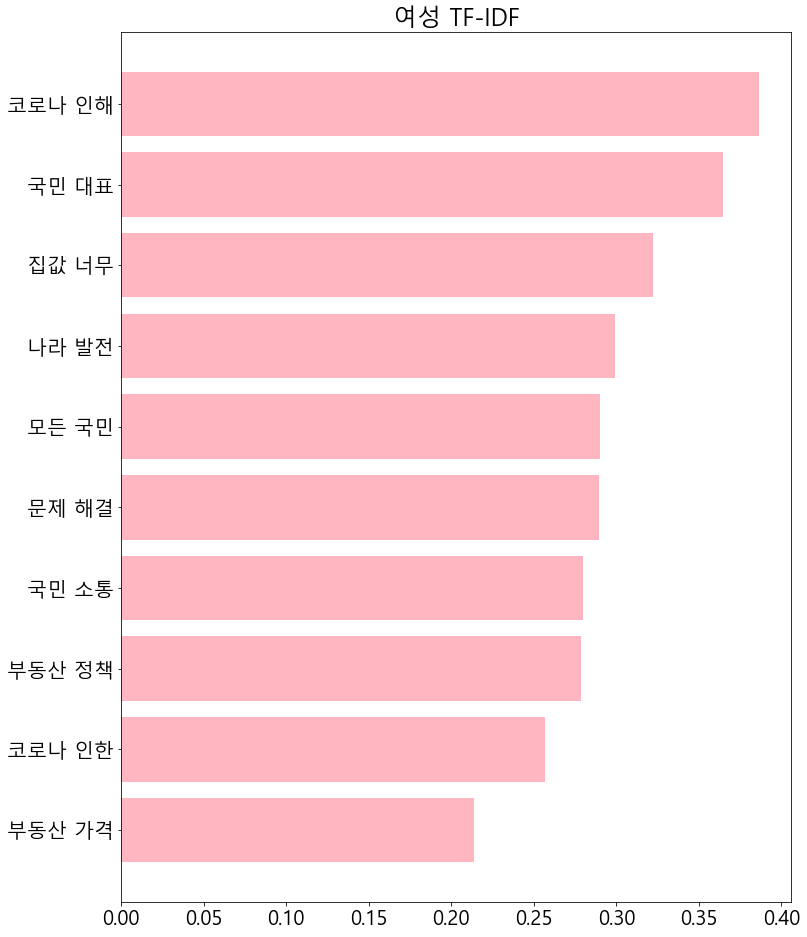

['좋은 나라 만들기', '나라 대표 국민', '코로나 이후 경제', '코로나 경제 많이', '집값 너무 올라서', '부동산 가격 너무', '부동산 가격 폭등', '부동산 정책 실패', '코로나 인한 경제', '살기 좋은 나라']
[0.18036357110089307, 0.18518260252821134, 0.21916673735428457, 0.22221912303385358, 0.26133754182767255, 0.27234131785879645, 0.2822818171655879, 0.30180540407179246, 0.32475195747531843, 0.397688241579555]


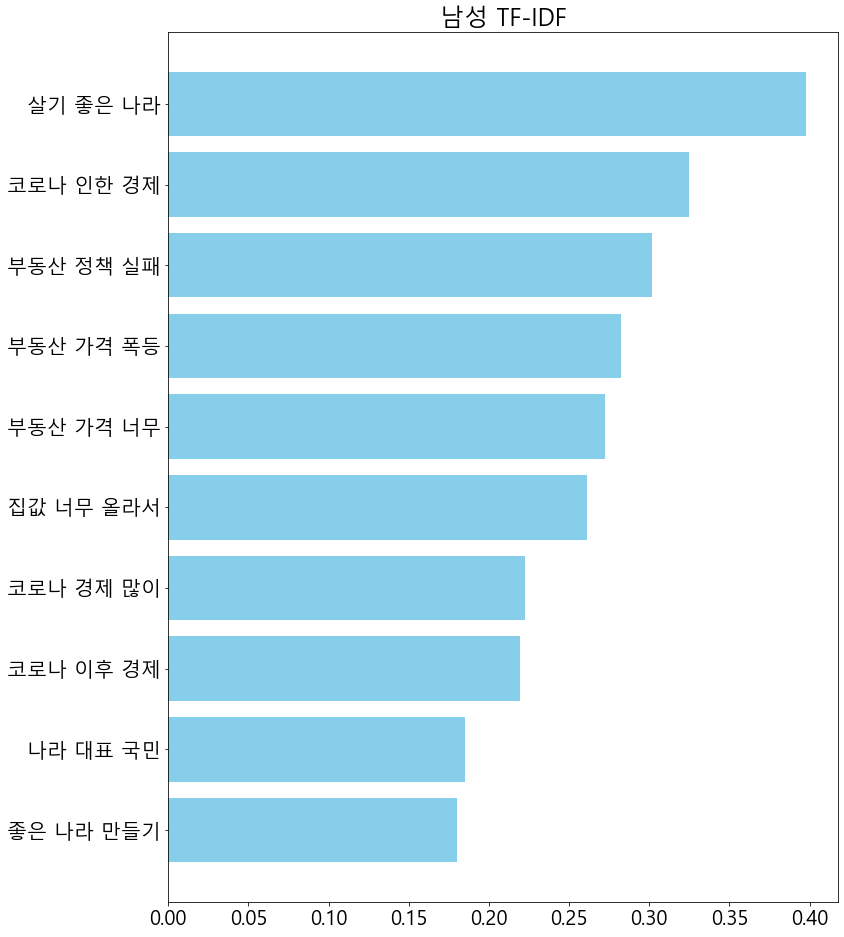

['코로나 경제 많이', '코로나 이후 경제', '좋은 나라 만들기', '살기 너무 힘들다', '부동산 가격 폭등', '부동산 가격 너무', '부동산 정책 실패', '집값 너무 올라서', '코로나 인한 경제', '살기 좋은 나라']
[0.10025658623637622, 0.11457895569871568, 0.13131197181758814, 0.13131197181758814, 0.1527425871266384, 0.20828534608177965, 0.2329444903414325, 0.2915994845144915, 0.2978141696984509, 0.7668871758841488]


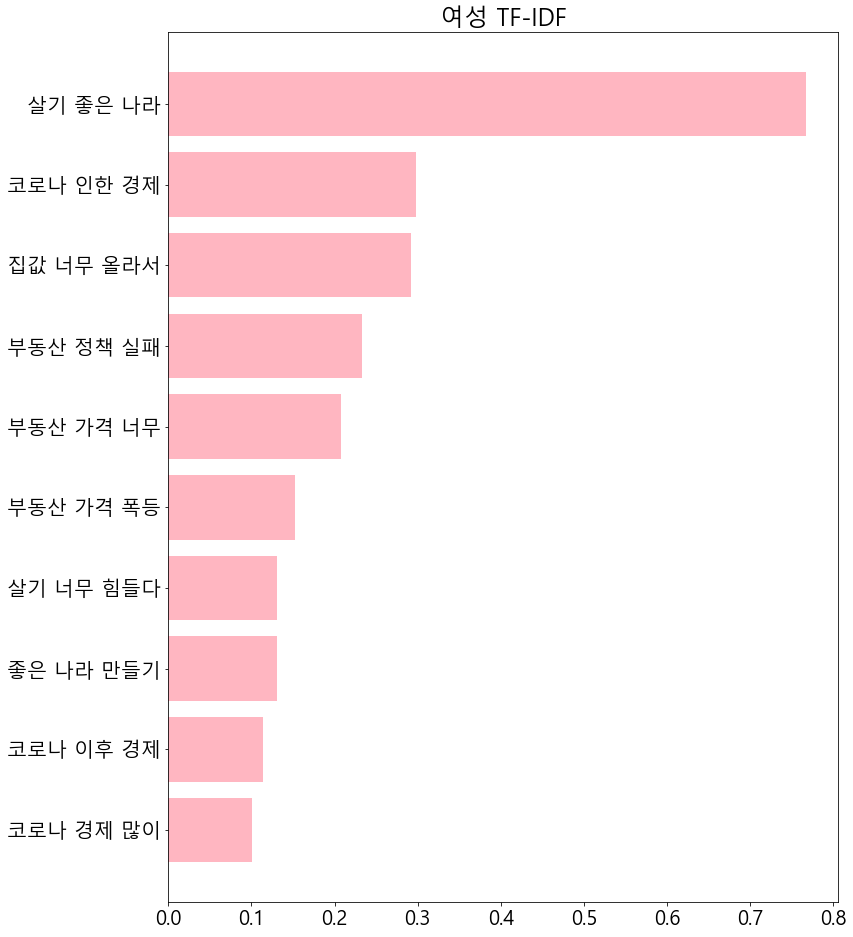

In [18]:
word_male1_q2, vec_male1_q2 = tfidf_analyze(prepro_female_q2, prepro_male_q2, tfidf_ngram1_q2, 'skyblue', '남성')
word_female1_q2, vec_female1_q2 = tfidf_analyze(prepro_male_q2, prepro_female_q2, tfidf_ngram1_q2, 'lightpink', '여성')

word_male2_q2, vec_male2_q2 = tfidf_analyze(prepro_female_q2, prepro_male_q2, tfidf_ngram2_q2, 'skyblue', '남성')
word_female2_q2, vec_female2_q2 = tfidf_analyze(prepro_male_q2, prepro_female_q2, tfidf_ngram2_q2, 'lightpink', '여성')

word_male3_q2, vec_male3_q2 = tfidf_analyze(prepro_female_q2, prepro_male_q2, tfidf_ngram3_q2, 'skyblue', '남성')
word_female3_q2, vec_female3_q2 = tfidf_analyze(prepro_male_q2, prepro_female_q2, tfidf_ngram3_q2, 'lightpink', '여성')

In [ ]:
# Q2
# 1ngram 용 남성
q2_male_1ngram_cos_df = cosine_sim_1ngram(tfidf_ngram1_q2, prepro_female_q2, prepro_male_q2, word_male1_q2, male_q2, 10)
# q2_male_1ngram_cos_df.to_csv('./Q2_남성(1ngram).csv', encoding='utf-8-sig', index=False)

# 1ngram 용 여성
q2_female_1ngram_cos_df = cosine_sim_1ngram(tfidf_ngram1_q2, prepro_male_q2, prepro_female_q2, word_female1_q2, female_q2, 10)
# q2_female_1ngram_cos_df.to_csv('./Q2_여성(1ngram).csv', encoding='utf-8-sig', index=False)

In [ ]:
# Q2
# 2ngram 용 남성
q2_male_2ngram_df  = cosine_sim_matching(tfidf_ngram2_q2, prepro_female_q2, prepro_male_q2, word_male2_q2, male_q2)
# q2_male_2ngram_df.to_csv('./Q2_남성(2ngram).csv', encoding='utf-8-sig', index=False)

# 2ngram 용 여성
q2_female_2ngram_df  = cosine_sim_matching(tfidf_ngram2_q2, prepro_male_q2, prepro_female_q2, word_female2_q2, female_q2)
# q2_female_2ngram_df.to_csv('./Q2_여성(2ngram).csv', encoding='utf-8-sig', index=False)

In [ ]:
# Q2
# 3ngram 용 남성
q2_male_df  = cosine_sim_matching(tfidf_ngram3_q2, prepro_female_q2, prepro_male_q2, word_male3_q2, male_q2)
q2_male_df.to_csv('./Q2_남성(3ngram).csv', encoding='utf-8-sig', index=False)

# 3ngram 용 여성
q2_female_df  = cosine_sim_matching(tfidf_ngram3_q2, prepro_male_q2, prepro_female_q2, word_female3_q2, female_q2)
q2_female_df.to_csv('./Q2_여성(3ngram).csv', encoding='utf-8-sig', index=False)

## 연령대 비교

### Q1 30대 이하 vs 40대 이상

In [40]:
# 불용어사전
stop_words_for_age1 = ['있는', '하는']

# 백터라이저
age_tfidf_ngram1 = TfidfVectorizer(
    stop_words=stop_words_for_age1,
    #max_df = 30,
    min_df = 100,
    ngram_range = (1,1),
    max_features = 50
)

# 불용어사전
stop_words_for_age2 = ['있는', '하는']

# 백터라이저
age_tfidf_ngram2 = TfidfVectorizer(
    stop_words=stop_words_for_age2,
    #max_df = 30,
    min_df = 50,
    ngram_range = (2,2),
    max_features = 50
)

# 불용어사전
stop_words_for_age3 = ['필요하다고', '있는']

# 백터라이저
age_tfidf_ngram3 = TfidfVectorizer(
    stop_words=stop_words_for_age3,
    #max_df = 30,
    min_df = 10,
    ngram_range = (3,3),
    max_features = 50
)

In [ ]:
# TF-IDF 그래프 & 단어,vector 추출

word1_under40_q1, vec1_under40_q1 = tfidf_analyze(prepro_age_over40_q1, prepro_age_under40_q1, age_tfidf_ngram1, 'skyblue', '30대 이하')
word1_over40_q1, vec1_over40_q1 = tfidf_analyze(prepro_age_under40_q1, prepro_age_over40_q1, age_tfidf_ngram1, 'lightpink', '40대 이상')

word2_under40_q1, vec2_under40_q1 = tfidf_analyze(prepro_age_over40_q1, prepro_age_under40_q1, age_tfidf_ngram2, 'skyblue', '30대 이하')
word2_over40_q1, vec2_over40_q1 = tfidf_analyze(prepro_age_under40_q1, prepro_age_over40_q1, age_tfidf_ngram2, 'lightpink', '40대 이상')

word3_under40_q1, vec3_under40_q1 = tfidf_analyze(prepro_age_over40_q1, prepro_age_under40_q1, age_tfidf_ngram3, 'skyblue', '30대 이하')
word3_over40_q1, vec3_over40_q1 = tfidf_analyze(prepro_age_under40_q1, prepro_age_over40_q1, age_tfidf_ngram3, 'lightpink', '40대 이상')

#### 코사인 유사도 매칭 대표문장

In [45]:
# Q1_1ngram

# 30대 이하
q1_under30_1ngram_cos_df = cosine_sim_1ngram(age_tfidf_ngram1, prepro_age_over40_q1, prepro_age_under40_q1, word1_under40_q1, age_under40_q1[age_under40_q1.notnull()], 10)
# q1_under30_1ngram_cos_df.to_csv('./Q1_30대이하(1ngram).csv', encoding='utf-8-sig', index=False)

# 40대 이상
q1_over40_1ngram_cos_df = cosine_sim_1ngram(age_tfidf_ngram1, prepro_age_under40_q1, prepro_age_over40_q1, word1_over40_q1, age_over40_q1[age_over40_q1.notnull()], 10)
# q1_over40_1ngram_cos_df.to_csv('./Q1_40대이상(1ngram).csv', encoding='utf-8-sig', index=False)

In [47]:
# Q1_2ngram

# 30대 이하
q1_under30_2ngram_cos_df = cosine_sim_matching(age_tfidf_ngram2, prepro_age_over40_q1, prepro_age_under40_q1, word2_under40_q1, age_under40_q1[age_under40_q1.notnull()])
# q1_under30_2ngram_cos_df.to_csv('./Q1_30대이하(2ngram).csv', encoding='utf-8-sig', index=False)

# 40대 이상
q1_over40_2ngram_cos_df = cosine_sim_matching(age_tfidf_ngram2, prepro_age_under40_q1, prepro_age_over40_q1, word2_over40_q1, age_over40_q1[age_over40_q1.notnull()])
# q1_over40_2ngram_cos_df.to_csv('./Q1_40대이상(2ngram).csv', encoding='utf-8-sig', index=False)

In [49]:
# Q1_3ngram

# 30대 이하
q1_under30_3ngram_cos_df = cosine_sim_matching(age_tfidf_ngram3, prepro_age_over40_q1, prepro_age_under40_q1, word3_under40_q1, age_under40_q1[age_under40_q1.notnull()])
# q1_under30_3ngram_cos_df.to_csv('./Q1_30대이하(3ngram).csv', encoding='utf-8-sig', index=False)

# 40대 이상
q1_over40_3ngram_cos_df = cosine_sim_matching(age_tfidf_ngram3, prepro_age_under40_q1, prepro_age_over40_q1, word3_over40_q1, age_over40_q1[age_over40_q1.notnull()])
# q1_over40_3ngram_cos_df.to_csv('./Q1_40대이상(3ngram).csv', encoding='utf-8-sig', index=False)

### Q2 30대 이하 vs 40대 이상

In [51]:
# 불용어사전
stop_words_for_age1_q2 = ['있는', '하는', '너무', '위해', '때문', '지금', '한다', '현재']

# 백터라이저
age_tfidf_ngram1_q2 = TfidfVectorizer(
    stop_words=stop_words_for_age1_q2,
    #max_df = 30,
    min_df = 100,
    ngram_range = (1,1),
    max_features = 50
)

# 불용어사전
stop_words_for_age2_q2 = ['있는', '하는', '있기', '때문', '생각', '한다', '합니다', '필요하다고', '이기', '때문', '하기', '입니다', '역량', '자질', '모든']

# 백터라이저
age_tfidf_ngram2_q2 = TfidfVectorizer(
    stop_words=stop_words_for_age2_q2,
    #max_df = 30,
    min_df = 30,
    ngram_range = (2,2),
    max_features = 50
)

# 불용어사전
stop_words_for_age3_q2 = ['필요하다고', '있는', '하기', '때문', '한다고', '합니다', '입니다', '있기', '이기', '위해', '되어야', '생각', '한다고', '가장', '문제', '사람']

# 백터라이저
age_tfidf_ngram3_q2 = TfidfVectorizer(
    stop_words=stop_words_for_age3_q2,
    #max_df = 30,
    min_df = 5,
    ngram_range = (3,3),
    max_features = 50
)

In [ ]:
# TF-IDF 그래프 & 단어,vector 추출

word1_under40_q2, vec1_under40_q2 = tfidf_analyze(prepro_age_over40_q2, prepro_age_under40_q2, age_tfidf_ngram1_q2, 'skyblue', '30대 이하')
word1_over40_q2, vec1_over40_q2 = tfidf_analyze(prepro_age_under40_q2, prepro_age_over40_q2, age_tfidf_ngram1_q2, 'lightpink', '40대 이상')

word2_under40_q2, vec2_under40_q2 = tfidf_analyze(prepro_age_over40_q2, prepro_age_under40_q2, age_tfidf_ngram2_q2, 'skyblue', '30대 이하')
word2_over40_q2, vec2_over40_q2 = tfidf_analyze(prepro_age_under40_q2, prepro_age_over40_q2, age_tfidf_ngram2_q2, 'lightpink', '40대 이상')

word3_under40_q2, vec3_under40_q2 = tfidf_analyze(prepro_age_over40_q2, prepro_age_under40_q2, age_tfidf_ngram3_q2, 'skyblue', '30대 이하')
word3_over40_q2, vec3_over40_q2 = tfidf_analyze(prepro_age_under40_q2, prepro_age_over40_q2, age_tfidf_ngram3_q2, 'lightpink', '40대 이상')

#### 코사인 유사도 매칭 대표문장

In [53]:
# Q2_1ngram

# 30대 이하
q2_under30_1ngram_cos_df = cosine_sim_1ngram(age_tfidf_ngram1_q2, prepro_age_over40_q2, prepro_age_under40_q2, word1_under40_q2, age_under40_q2[age_under40_q2.notnull()], 10)
# q2_under30_1ngram_cos_df.to_csv('./Q2_30대이하(1ngram).csv', encoding='utf-8-sig', index=False)

# 40대 이상
q2_over40_1ngram_cos_df = cosine_sim_1ngram(age_tfidf_ngram1_q2, prepro_age_under40_q2, prepro_age_over40_q2, word1_over40_q2, age_over40_q2[age_over40_q2.notnull()], 10)
# q2_over40_1ngram_cos_df.to_csv('./Q2_40대이상(1ngram).csv', encoding='utf-8-sig', index=False)

In [55]:
# Q2_2ngram

# 30대 이하
q2_under30_2ngram_cos_df = cosine_sim_matching(age_tfidf_ngram2_q2, prepro_age_over40_q2, prepro_age_under40_q2, word2_under40_q2, age_under40_q2[age_under40_q2.notnull()])
# q2_under30_2ngram_cos_df.to_csv('./Q2_30대이하(2ngram).csv', encoding='utf-8-sig', index=False)

# 40대 이상
q2_over40_2ngram_cos_df = cosine_sim_matching(age_tfidf_ngram2_q2, prepro_age_under40_q2, prepro_age_over40_q2, word2_over40_q2, age_over40_q2[age_over40_q2.notnull()])
# q2_over40_2ngram_cos_df.to_csv('./Q2_40대이상(2ngram).csv', encoding='utf-8-sig', index=False)

In [58]:
# Q2_3ngram

# 30대 이하
q2_under30_3ngram_cos_df = cosine_sim_matching(age_tfidf_ngram3_q2, prepro_age_over40_q2, prepro_age_under40_q2, word3_under40_q2, age_under40_q2[age_under40_q2.notnull()])
# q2_under30_3ngram_cos_df.to_csv('./Q2_30대이하(3ngram).csv', encoding='utf-8-sig', index=False)

# 40대 이상
q2_over40_3ngram_cos_df = cosine_sim_matching(age_tfidf_ngram3_q2, prepro_age_under40_q2, prepro_age_over40_q2, word3_over40_q2, age_over40_q2[age_over40_q2.notnull()])
# q2_over40_3ngram_cos_df.to_csv('./Q2_40대이상(3ngram).csv', encoding='utf-8-sig', index=False)

### Q1 10~60대 연령 비교

In [43]:
# 불용어사전
age_stop_words_q1 = ['되었으면', '좋겠다', '의한', '필요하다고', '하는', '하지', '한다고', '중요하다고', '야한다고', '할수', '있는']

# 백터라이저
age_tfidf_ngram_q1 = TfidfVectorizer(
    stop_words=age_stop_words_q1,
    max_df = 30,
    #min_df = 100,
    ngram_range = (3,3),
    max_features = 50
)

#### TF-IDF 그래프 & 단어,vector 추출

In [ ]:
word_age10_q1, vec_age10_q1 = tfidf_analyze(prepro_allage_q1, prepro_age10_q1, age_tfidf_ngram_q1, 'skyblue', '10대')


In [ ]:
word_age10_q1, vec_age10_q1 = tfidf_analyze(prepro_age10_q1, prepro_age10_q1, age_tfidf_ngram_q1, 'skyblue', '10대')

In [ ]:
word_age20_q1, vec_age20_q1 = tfidf_analyze(prepro_allage_q1, prepro_age20_q1, age_tfidf_ngram_q1, 'lightpink', '20대')

In [ ]:
word_age20_q1, vec_age20_q1 = tfidf_analyze(prepro_age20_q1, prepro_age20_q1, age_tfidf_ngram_q1, 'lightpink', '20대')

In [ ]:
word_age30_q1, vec_age30_q1 = tfidf_analyze(prepro_allage_q1, prepro_age30_q1, age_tfidf_ngram_q1, 'tab:orange', '30대')

In [ ]:
word_age30_q1, vec_age30_q1 = tfidf_analyze(prepro_age30_q1, prepro_age30_q1, age_tfidf_ngram_q1, 'tab:orange', '30대')

In [ ]:
word_age40_q1, vec_age40_q1 = tfidf_analyze(prepro_allage_q1, prepro_age40_q1, age_tfidf_ngram_q1, 'tab:green', '40대')

In [ ]:
word_age40_q1, vec_age40_q1 = tfidf_analyze(prepro_age40_q1, prepro_age40_q1, age_tfidf_ngram_q1, 'tab:green', '40대')

In [ ]:
word_age50_q1, vec_age50_q1 = tfidf_analyze(prepro_allage_q1, prepro_age50_q1, age_tfidf_ngram_q1, 'tab:purple', '50대')

In [ ]:
word_age50_q1, vec_age50_q1 = tfidf_analyze(prepro_age50_q1, prepro_age50_q1, age_tfidf_ngram_q1, 'tab:purple', '50대')

In [ ]:
word_age60_q1, vec_age60_q1 = tfidf_analyze(prepro_allage_q1, prepro_age60_q1, age_tfidf_ngram_q1, 'tab:gray', '60대')

In [ ]:
word_age60_q1, vec_age60_q1 = tfidf_analyze(prepro_age60_q1, prepro_age60_q1, age_tfidf_ngram_q1, 'tab:gray', '60대')

#### 코사인 유사도 매칭 대표문장

In [71]:
q1_age10_df  = cosine_sim_matching(age_tfidf_ngram_q1, prepro_age10_q1, prepro_age10_q1, word_age10_q1, age10_q1)
q1_age10_df.to_csv('./Q1_10대.csv', encoding='utf-8-sig', index=False)

q1_age20_df  = cosine_sim_matching(age_tfidf_ngram_q1, prepro_age20_q1, prepro_age20_q1, word_age20_q1, age20_q1)
q1_age20_df.to_csv('./Q1_20대.csv', encoding='utf-8-sig', index=False)

q1_age30_df  = cosine_sim_matching(age_tfidf_ngram_q1, prepro_age30_q1, prepro_age30_q1, word_age30_q1, age30_q1)
q1_age30_df.to_csv('./Q1_30대.csv', encoding='utf-8-sig', index=False)

q1_age40_df  = cosine_sim_matching(age_tfidf_ngram_q1, prepro_age40_q1, prepro_age40_q1, word_age40_q1, age40_q1)
q1_age40_df.to_csv('./Q1_40대.csv', encoding='utf-8-sig', index=False)

q1_age50_df  = cosine_sim_matching(age_tfidf_ngram_q1, prepro_age50_q1, prepro_age50_q1, word_age50_q1, age50_q1)
q1_age50_df.to_csv('./Q1_50대.csv', encoding='utf-8-sig', index=False)

q1_age60_df  = cosine_sim_matching(age_tfidf_ngram_q1, prepro_age60_q1, prepro_age60_q1, word_age60_q1, age60_q1)
q1_age60_df.to_csv('./Q1_60대.csv', encoding='utf-8-sig', index=False)

### Q2 10~60대 연령 비교

In [66]:
# 불용어사전
age_stop_words_q2 = ['되었으면', '좋겠다', '의한', '필요하다고', '하는', '하지', '한다고', '중요하다고', '야한다고', '생각', '하기', '때문', '사람', '역량', '자질', '이기', '되기', '현재', '가장', '해야', '대표', '인물', '라면']

# 백터라이저
age_tfidf_ngram_q2 = TfidfVectorizer(
    stop_words=age_stop_words_q2,
    #max_df = 30,
    min_df = 2,
    ngram_range = (3,3),
    max_features = 50
)

#### TF-IDF 그래프 & 단어,vector 추출

In [ ]:
word_age10_q2, vec_age10_q2 = tfidf_analyze(prepro_allage_q2, prepro_age10_q2, age_tfidf_ngram_q2, 'skyblue', '10대')
# word_age10_q2, vec_age10_q2 = tfidf_analyze(prepro_age10_q2, prepro_age10_q2, age_tfidf_ngram_q2, 'skyblue', '10대')

word_age20_q2, vec_age20_q2 = tfidf_analyze(prepro_allage_q2, prepro_age20_q2, age_tfidf_ngram_q2, 'lightpink', '20대')
# word_age20_q2, vec_age20_q2 = tfidf_analyze(prepro_age20_q2, prepro_age20_q2, age_tfidf_ngram_q2, 'lightpink', '20대')

word_age30_q2, vec_age30_q2 = tfidf_analyze(prepro_allage_q2, prepro_age30_q2, age_tfidf_ngram_q2, 'tab:orange', '30대')
# word_age30_q2, vec_age30_q2 = tfidf_analyze(prepro_age30_q2, prepro_age30_q2, age_tfidf_ngram_q2, 'tab:orange', '30대')

word_age40_q2, vec_age40_q2 = tfidf_analyze(prepro_allage_q2, prepro_age40_q2, age_tfidf_ngram_q2, 'tab:green', '40대')
# word_age40_q2, vec_age40_q2 = tfidf_analyze(prepro_age40_q2, prepro_age40_q2, age_tfidf_ngram_q2, 'tab:green', '40대')

word_age50_q2, vec_age50_q2 = tfidf_analyze(prepro_allage_q2, prepro_age50_q2, age_tfidf_ngram_q2, 'tab:purple', '50대')
# word_age50_q2, vec_age50_q2 = tfidf_analyze(prepro_age50_q2, prepro_age50_q2, age_tfidf_ngram_q2, 'tab:purple', '50대')

word_age60_q2, vec_age60_q2 = tfidf_analyze(prepro_allage_q2, prepro_age60_q2, age_tfidf_ngram_q2, 'tab:gray', '60대')
# word_age60_q2, vec_age60_q2 = tfidf_analyze(prepro_age60_q2, prepro_age60_q2, age_tfidf_ngram_q2, 'tab:gray', '60대')

#### 코사인 유사도 매칭 대표문장

In [68]:
q2_age10_df  = cosine_sim_matching(age_tfidf_ngram_q2, prepro_allage_q2, prepro_age10_q2, word_age10_q2, age10_q2)
# q2_age10_df.to_csv('./Q2_10대.csv', encoding='utf-8-sig', index=False)

q2_age20_df  = cosine_sim_matching(age_tfidf_ngram_q2, prepro_allage_q2, prepro_age20_q2, word_age20_q2, age20_q2)
# q2_age20_df.to_csv('./Q2_20대.csv', encoding='utf-8-sig', index=False)

q2_age30_df  = cosine_sim_matching(age_tfidf_ngram_q2, prepro_allage_q2, prepro_age30_q2, word_age30_q2, age30_q2)
# q2_age30_df.to_csv('./Q2_30대.csv', encoding='utf-8-sig', index=False)

q2_age40_df  = cosine_sim_matching(age_tfidf_ngram_q2, prepro_allage_q2, prepro_age40_q2, word_age40_q2, age40_q2)
# q2_age40_df.to_csv('./Q2_40대.csv', encoding='utf-8-sig', index=False)

q2_age50_df  = cosine_sim_matching(age_tfidf_ngram_q2, prepro_allage_q2, prepro_age50_q2, word_age50_q2, age50_q2)
# q2_age50_df.to_csv('./Q2_50대.csv', encoding='utf-8-sig', index=False)

q2_age60_df  = cosine_sim_matching(age_tfidf_ngram_q2, prepro_allage_q2, prepro_age60_q2, word_age60_q2, age60_q2)
# q2_age60_df.to_csv('./Q2_60대.csv', encoding='utf-8-sig', index=False)

# 로그오즈비

### Q1 성별 비교

In [ ]:
# 빈도 구하기
q1_gender_stop_words = ['있는', '하는', '생각']

q1_gender_count = CountVectorizer(
    stop_words = q1_gender_stop_words,
    max_features = 100,
    min_df = 100
)

q1_male_word, q1_male_vec = count_analyze(prepro_male_q1, q1_gender_count, 'tab:blue', '남성')
q1_female_word, q1_female_vec = count_analyze(prepro_female_q1, q1_gender_count, 'tab:red', '여성')

# 로그오즈비 구현
q1_gender_log_df = log_odds_ratio(q1_gender_count, prepro_male_q1, prepro_female_q1, q1_male_word, q1_female_word, 'Q1_남여')

### Q2 성별 비교

In [ ]:
# 빈도 구하기
q2_gender_stop_words = ['있는', '하는', '생각', '하기', '때문', '너무', '위해', '지금', '현재', '가장', '한다',
                        '합니다', '역량', '자질', '해서', '이기', '필요하다고', '많이']

q2_gender_count = CountVectorizer(
    stop_words = q2_gender_stop_words,
    max_features = 100,
    min_df = 100
)

q2_male_word, q2_male_vec = count_analyze(prepro_male_q2, q2_gender_count, 'tab:blue', '남성')
q2_female_word, q2_female_vec = count_analyze(prepro_female_q2, q2_gender_count, 'tab:red', '여성')

# 로그오즈비 구현
q2_gender_log_df = log_odds_ratio(q2_gender_count, prepro_male_q2, prepro_female_q2, q2_male_word, q2_female_word, 'Q2_남여')

### Q1 연령 비교

In [ ]:
# 빈도 구하기
q1_age_stop_words = ['있는', '하는', '생각']

q1_age_count = CountVectorizer(
    stop_words = q1_age_stop_words,
    max_features = 100,
    min_df = 100
)

q1_under40_word, q1_under40_vec = count_analyze(prepro_age_under40_q1, q1_age_count, 'tab:blue', '30대 이하')
q1_over40_word, q1_over40_vec = count_analyze(prepro_age_over40_q1, q1_age_count, 'tab:red', '40대 이상')

# 로그오즈비 구현
q1_age_log_df = log_odds_ratio(q1_age_count, prepro_age_under40_q1, prepro_age_over40_q1, q1_under40_word, q1_over40_word, 'Q1_연령')

### Q2 연령 비교

In [ ]:
# 빈도 구하기
q2_age_stop_words = ['있는', '하는', '생각', '하기', '때문', '너무', '위해', '지금', '현재', '가장', '한다',
                        '합니다', '역량', '자질', '해서', '이기', '필요하다고', '많이', '해야', '살기']

q2_age_count = CountVectorizer(
    stop_words = q2_age_stop_words,
    max_features = 100,
    min_df = 100
)

q2_under40_word, q2_under40_vec = count_analyze(prepro_age_under40_q2, q2_age_count, 'tab:blue', '30대 이하')
q2_over40_word, q2_over40_vec = count_analyze(prepro_age_over40_q2, q2_age_count, 'tab:red', '40대 이상')

# 로그오즈비 구현
q2_age_log_df = log_odds_ratio(q2_age_count, prepro_age_under40_q2, prepro_age_over40_q2, q2_under40_word, q2_over40_word, 'Q2_연령')